## **Importing Necessary Libraries**

In [28]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from IPython import display
from tqdm import tqdm  # For progress bar

## 1. **Dataset Loading**

In [29]:
# Define the dataset directory
dataset_dir = "C:/Users/SPPL IT/Desktop/Study/CVPR_ASSIGNMENT/CVPR/MID/Animals"

def load_images(dataset_dir, img_size=(64, 64)):
    """
    Loads images and their corresponding labels based on folder names,
    resizes them to a uniform size, and shuffles the dataset.

    Args:
        dataset_dir (str): Path to the dataset root folder.
        img_size (tuple): Desired image size for resizing (width, height).

    Returns:
        np.ndarray: Shuffled images as a NumPy array.
        np.ndarray: Shuffled labels corresponding to each image.
        list: List of unique class names.
    """
    images = []
    labels = []
    class_names = sorted(os.listdir(dataset_dir))  # Ensure consistent ordering
    print(f"Detected classes: {class_names}")

    for class_name in tqdm(class_names, desc="Loading dataset"):
        class_path = os.path.join(dataset_dir, class_name)

        # Ensure the directory corresponds to a class
        if not os.path.isdir(class_path):
            print(f"Skipping {class_name}, not a directory.")
            continue

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                # Read and preprocess the image
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
                img = cv2.resize(img, img_size)  # Resize image to uniform size
                images.append(img)
                labels.append(class_name)  # Use the folder name as the label
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

    # Convert to NumPy arrays
    images = np.array(images)
    labels = np.array(labels)

    # Shuffle the dataset
    print("Shuffling the dataset...")
    indices = np.arange(len(images))
    np.random.shuffle(indices)  # Randomly shuffle indices
    images = images[indices]
    labels = labels[indices]

    return images, labels, class_names

# Load dataset and verify
#dataset_dir = "path_to_dataset"  # Specify your dataset path
X, y, class_names = load_images(dataset_dir)
print(f"Loaded {len(X)} images with corresponding labels.")


Detected classes: ['Cheetah', 'Jaguar', 'Leopard', 'Lion', 'Tiger']


Loading dataset: 100%|██████████| 5/5 [00:00<00:00,  6.72it/s]

Shuffling the dataset...
Loaded 170 images with corresponding labels.


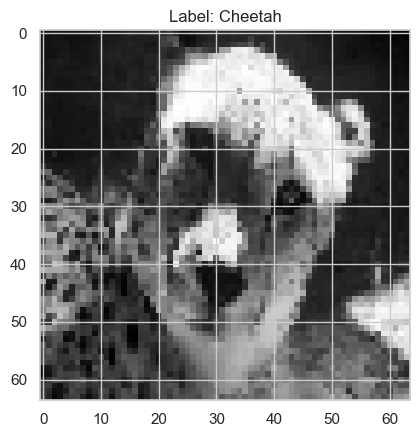

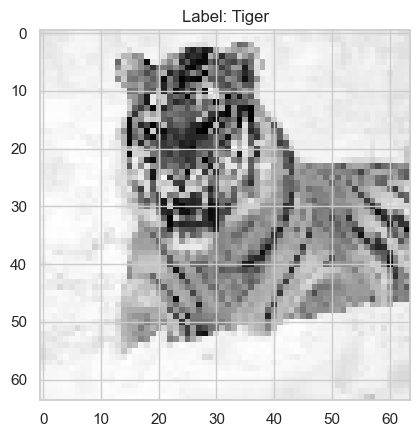

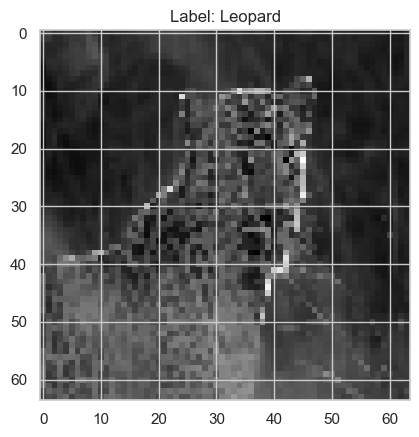

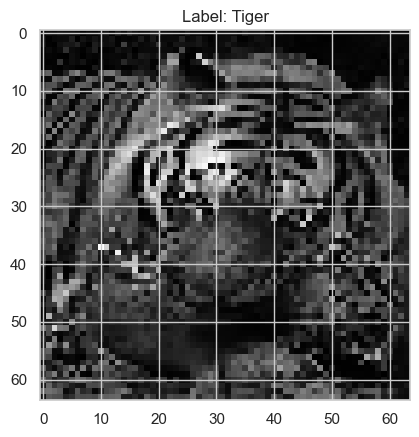

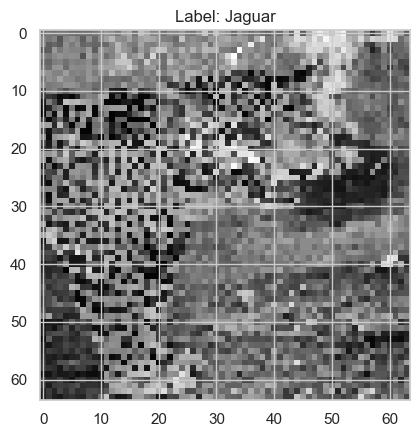

In [ ]:
for i in range(5):
    plt.imshow(X[i], cmap="gray")  
    plt.title(f"Label: {y[i]}")
    plt.show()


## **2. Data Preprocessing**

In [31]:
# Reshape images into 1D feature vectors and normalize pixel values
X = X.reshape(X.shape[0], -1).astype("float32") / 255.0
print(f"Reshaped dataset into {X.shape[0]} samples with {X.shape[1]} features each.")


Reshaped dataset into 170 samples with 4096 features each.


### **3. 5-Fold Cross-Validation Setup**

In [32]:
def create_folds(X, y, num_folds=5):
    """
    Splits the dataset into num_folds for cross-validation.

    Args:
        X (np.ndarray): Feature matrix.
        y (np.ndarray): Labels.
        num_folds (int): Number of folds.

    Returns:
        list: List of folds, where each fold contains indices for the validation set.
    """
    indices = np.arange(len(X))
    np.random.shuffle(indices)  # Shuffle the dataset indices again for randomness
    folds = np.array_split(indices, num_folds)
    return folds

# Generate 5 folds
num_folds = 5
folds = create_folds(X, y, num_folds)
print(f"Dataset divided into {num_folds} folds.")


Dataset divided into 5 folds.


## **4. k-NN Classification with Euclidean Distance**

In [33]:
def euclidean_distance(x1, x2):
    """
    Computes the Euclidean (L2) distance between two points.

    Args:
        x1 (np.ndarray): A single point or array of points.
        x2 (np.ndarray): Another single point.

    Returns:
        np.ndarray: Array of distances.
    """
    return np.sqrt(np.sum((x1 - x2) ** 2, axis=1))

def knn_classify(train_X, train_y, test_X, k):
    """
    Classifies test samples using k-Nearest Neighbors.

    Args:
        train_X (np.ndarray): Training features.
        train_y (np.ndarray): Training labels.
        test_X (np.ndarray): Test features.
        k (int): Number of nearest neighbors.

    Returns:
        np.ndarray: Predicted labels for test samples.
    """
    predictions = []
    for test_point in tqdm(test_X, desc=f"Classifying with k={k}"):
        distances = euclidean_distance(train_X, test_point)
        k_nearest_indices = np.argsort(distances)[:k]  # Get indices of k nearest neighbors
        k_nearest_labels = train_y[k_nearest_indices]
        unique_labels, counts = np.unique(k_nearest_labels, return_counts=True)
        predictions.append(unique_labels[np.argmax(counts)])  # Majority vote
    return np.array(predictions)


**5. Cross-Validation and Accuracy Calculation**

In [34]:
# List of K values to evaluate
K_values = range(1, 31)

# Dictionary to store accuracies for each K
accuracies = {k: [] for k in K_values}

# Perform 5-fold cross-validation
for fold_idx in range(num_folds):
    print(f"Processing fold {fold_idx + 1}/{num_folds}")
    test_indices = folds[fold_idx]
    train_indices = np.setdiff1d(np.arange(len(X)), test_indices)

    train_X, train_y = X[train_indices], y[train_indices]
    test_X, test_y = X[test_indices], y[test_indices]

    for k in K_values:
        preds = knn_classify(train_X, train_y, test_X, k)
        accuracy = np.mean(preds == test_y)  # Compute accuracy
        accuracies[k].append(accuracy)


Processing fold 1/5


Classifying with k=30: 100%|██████████| 34/34 [00:00<00:00, 330.55it/s]


Processing fold 2/5


Classifying with k=30: 100%|██████████| 34/34 [00:00<00:00, 237.61it/s]


Processing fold 3/5


Classifying with k=30: 100%|██████████| 34/34 [00:00<00:00, 390.41it/s]


Processing fold 4/5


Classifying with k=30: 100%|██████████| 34/34 [00:00<00:00, 386.81it/s]


Processing fold 5/5


Classifying with k=30: 100%|██████████| 34/34 [00:00<00:00, 381.31it/s]


### **6.Average Accuracy and Centroid Calculation**

In [35]:
# Calculate average accuracy (centroid) for each K
avg_accuracies = {k: np.mean(acc) for k, acc in accuracies.items()}
print("Calculated centroid accuracies for each K.")


Calculated centroid accuracies for each K.


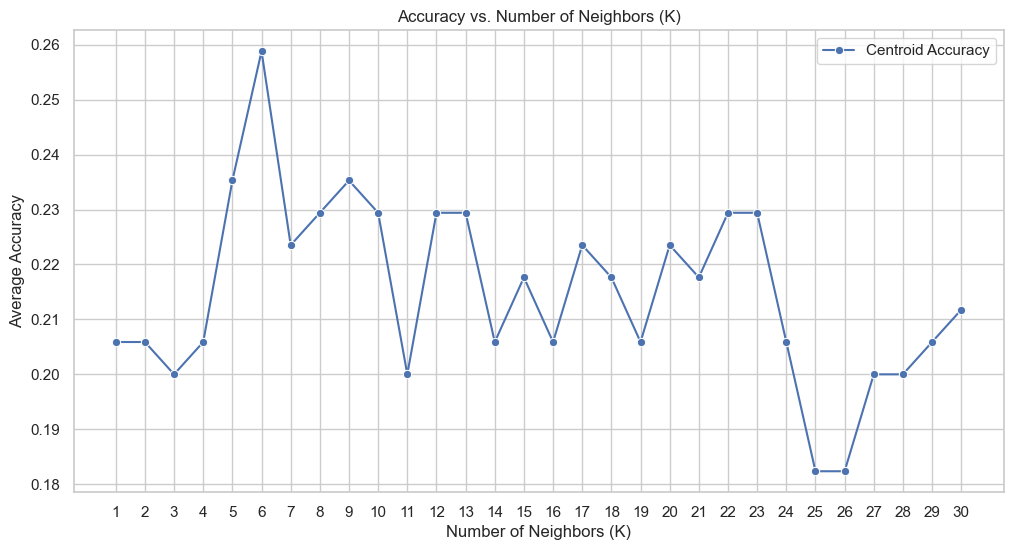

In [36]:
# Plotting results
plt.figure(figsize=(12, 6))
sns.lineplot(x=list(K_values), y=[avg_accuracies[k] for k in K_values], marker="o", label="Centroid Accuracy")
plt.title("Accuracy vs. Number of Neighbors (K)")
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Average Accuracy")
plt.xticks(K_values)
plt.grid(True)
plt.legend()
plt.show()


In [37]:
import plotly.graph_objs as go
import plotly.io as pio

# Plot the average accuracy vs K values
def plot_accuracy_trend(K_values, avg_accuracies):
    """
    Plots the average accuracy for each K value using Plotly.

    Args:
        K_values (range): Range of K values.
        avg_accuracies (dict): Dictionary with K as keys and average accuracies as values.
    """
    # Convert the dictionary to lists
    x = list(K_values)
    y = [avg_accuracies[k] for k in K_values]

    # Create a line plot with markers
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=x, y=y,
        mode='lines+markers',
        line=dict(color='rgb(228,26,28)', width=3),  # Set1 color theme
        marker=dict(size=8),
        hovertemplate='K=%{x}<br>Accuracy=%{y:.2%}',
        name='Average Accuracy'
    ))

    # Customize layout to fit your existing theme
    fig.update_layout(
        title="k-NN Classification Accuracy vs K",
        xaxis=dict(title='K Value', tickmode='linear', dtick=1),
        yaxis=dict(title='Average Accuracy', tickformat='.2%'),
        template='plotly_white',
        font=dict(family='Arial', size=14),
        height=500,
        width=800,
        showlegend=False,
        margin=dict(l=60, r=30, t=50, b=50),
        plot_bgcolor='white'
    )

    fig.update_xaxes(showgrid=True, gridcolor='lightgray')
    fig.update_yaxes(showgrid=True, gridcolor='lightgray')

    # Show the plot
    pio.show(fig)

# Call the function to plot the results
plot_accuracy_trend(K_values, avg_accuracies)
